In [83]:
### Part 3 – Unsupervised learning

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
## Load and prepare data

In [86]:
df = pd.read_csv('CASchools_processed.csv')
if 'student_teacher_ratio' not in df.columns:
    df['student_teacher_ratio'] = df['students'] / df['teachers']
if 'disadvantage_index' not in df.columns:
    df['disadvantage_index'] = (df['calworks'] + df['lunch'] + df['english']) / 3

features = ['students', 'calworks', 'lunch', 'income', 'english', 
            'student_teacher_ratio', 'disadvantage_index', 'read', 'math']
X = df[features]
X_scaled = StandardScaler().fit_transform(X)
true_labels = df['performance'].map({'Low': 0, 'Medium': 1, 'High': 2})

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [87]:
## Evaluate and visualize clusters with enhanced plots

In [88]:
def eval_clusters(labels, name, X=X_scaled, X2d=X_pca, y_true=true_labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        print(f"{name}: Insufficient clusters")
        return np.nan, np.nan
        
    ari = adjusted_rand_score(y_true, labels)
    sil = silhouette_score(X, labels) if n_clusters > 1 else np.nan
    
    # Plot clusters
    plt.figure(figsize=(7, 5))
    plt.scatter(X2d[:, 0], X2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title(f'{name}: ARI={ari:.3f}, SIL={sil:.3f}, n={n_clusters}')
    plt.savefig(f'cluster_{name.replace(" ", "_").replace("=", "").replace(".", "")}.png')
    plt.close()
    
    print(f"{name}: ARI={ari:.3f}, SIL={sil:.3f}")
    return ari, sil

# Plot original classes
plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
plt.title('Original Performance Classes')
plt.savefig('original_classes.png')
plt.close()

results = []

In [89]:
## ========== K-MEANS ==========

In [90]:
print("\n===== K-MEANS =====")
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    ari, sil = eval_clusters(labels, f"KMeans_k{k}")
    
    if not np.isnan(sil):
        results.append(('KMeans', f'k={k}', ari, sil))
        
        # Show class distribution
        plt.figure(figsize=(5, 4))
        pd.crosstab(df['performance'], pd.Series(labels, name='cluster')).plot(kind='bar', stacked=True)
        plt.title(f'KMeans k={k}')
        plt.savefig(f'km_k{k}_dist.png')
        plt.close()

# Elbow method
inertias = [KMeans(n_clusters=k, random_state=42).fit(X_scaled).inertia_ for k in range(1, 10)]
plt.figure(figsize=(6, 4))
plt.plot(range(1, 10), inertias, 'o-')
plt.title('K-Means Elbow Method')
plt.xlabel('k'), plt.ylabel('Inertia')
plt.grid(alpha=0.3)
plt.savefig('kmeans_elbow.png')
plt.close()



===== K-MEANS =====
KMeans_k2: ARI=0.253, SIL=0.355
KMeans_k3: ARI=0.294, SIL=0.312
KMeans_k4: ARI=0.253, SIL=0.259
KMeans_k5: ARI=0.226, SIL=0.264
KMeans_k6: ARI=0.262, SIL=0.211


<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

In [91]:
## ========== HIERARCHICAL ==========

In [92]:
print("\n===== HIERARCHICAL =====")
for method in ['ward', 'complete', 'average']:
    hc = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels = hc.fit_predict(X_scaled)
    ari, sil = eval_clusters(labels, f"HC_{method}")
    
    if not np.isnan(sil):
        results.append(('Hierarchical', method, ari, sil))

# Dendrograms (using sample)
X_sample = X_scaled[np.random.choice(len(X_scaled), min(100, len(X_scaled)), replace=False)]
plt.figure(figsize=(10, 4))
for i, method in enumerate(['ward', 'complete', 'average']):
    plt.subplot(1, 3, i+1)
    dendrogram(linkage(X_sample, method=method))
    plt.title(method)
plt.tight_layout()
plt.savefig('dendrograms.png')
plt.close()


===== HIERARCHICAL =====
HC_ward: ARI=0.268, SIL=0.324
HC_complete: ARI=0.226, SIL=0.310
HC_average: ARI=0.016, SIL=0.380


In [93]:
## ========== DBSCAN ==========

In [94]:
print("\n===== DBSCAN =====")
for eps in [0.34, 0.51, 0.75]:
    for min_samples in [5, 10, 15]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        print(f"DBSCAN eps={eps} min={min_samples}: {n_clusters} clusters, {n_noise} noise ({n_noise/len(labels):.1%})")
        
        if n_clusters > 1:
            ari, sil = eval_clusters(labels, f"DBSCAN_eps{eps}_min{min_samples}")
            
            if not np.isnan(sil):
                results.append(('DBSCAN', f'eps={eps}_min={min_samples}', ari, sil))
                
                try:
                    # Class distribution excluding noise
                    valid_idx = labels != -1
                    if sum(valid_idx) > 0:
                        plt.figure(figsize=(5, 4))
                        pd.crosstab(
                            pd.Series(true_labels[valid_idx], name='performance'),
                            pd.Series(labels[valid_idx], name='cluster')
                        ).plot(kind='bar', stacked=True)
                        plt.title(f'DBSCAN eps={eps} min={min_samples}')
                        plt.savefig(f'db_eps{eps}_min{min_samples}_dist.png')
                        plt.close()
                except:
                    pass


===== DBSCAN =====
DBSCAN eps=0.34 min=5: 0 clusters, 420 noise (100.0%)
DBSCAN eps=0.34 min=10: 0 clusters, 420 noise (100.0%)
DBSCAN eps=0.34 min=15: 0 clusters, 420 noise (100.0%)
DBSCAN eps=0.51 min=5: 2 clusters, 410 noise (97.6%)
DBSCAN_eps0.51_min5: ARI=-0.018, SIL=-0.300
DBSCAN eps=0.51 min=10: 0 clusters, 420 noise (100.0%)
DBSCAN eps=0.51 min=15: 0 clusters, 420 noise (100.0%)
DBSCAN eps=0.75 min=5: 4 clusters, 339 noise (80.7%)
DBSCAN_eps0.75_min5: ARI=-0.026, SIL=-0.300
DBSCAN eps=0.75 min=10: 1 clusters, 377 noise (89.8%)
DBSCAN eps=0.75 min=15: 1 clusters, 403 noise (96.0%)


<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

In [95]:
## Compare all methods

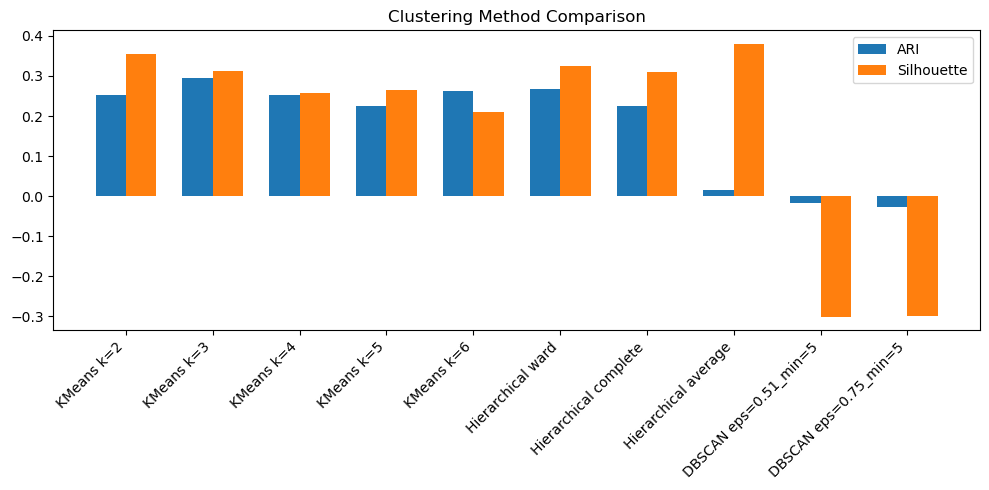

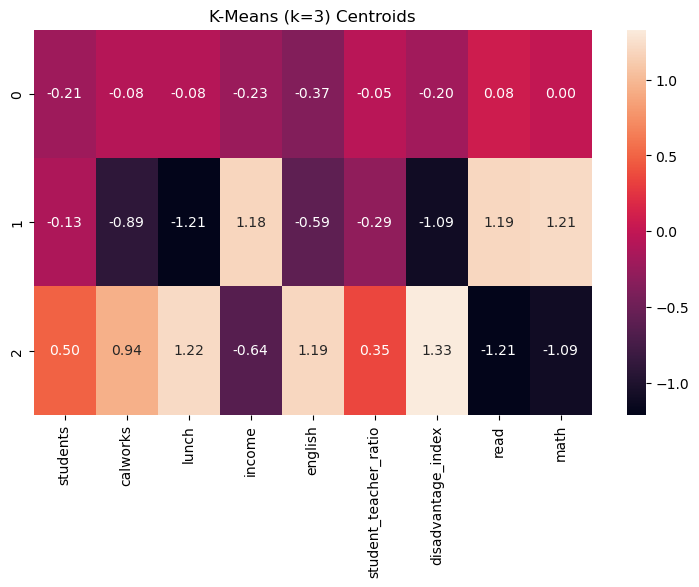

In [96]:

if results:
    methods = [f"{algo} {params}" for algo, params, _, _ in results]
    ari_scores = [ari for _, _, ari, _ in results]
    sil_scores = [sil for _, _, _, sil in results]
    
    plt.figure(figsize=(10, 5))
    x = np.arange(len(methods))
    width = 0.35
    plt.bar(x - width/2, ari_scores, width, label='ARI')
    plt.bar(x + width/2, sil_scores, width, label='Silhouette')
    plt.title('Clustering Method Comparison')
    plt.xticks(x, methods, rotation=45, ha='right')
    plt.legend(), plt.tight_layout()
    plt.savefig('cluster_comparison.png')
    
    # Feature analysis for K-Means k=3
    km3 = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
    plt.figure(figsize=(9, 5))
    sns.heatmap(pd.DataFrame(km3.cluster_centers_, columns=features), annot=True, fmt='.2f')
    plt.title('K-Means (k=3) Centroids')
    plt.savefig('kmeans_centroids.png')

In [97]:
## Summary

In [98]:
print("\n===== SUMMARY =====")
    
# Best by algorithm
for algo in set(r[0] for r in results):
    algo_results = [r for r in results if r[0] == algo]
    if algo_results:
        best = max(algo_results, key=lambda x: x[3])
        print(f"Best {algo}: {best[1]} (SIL={best[3]:.3f}, ARI={best[2]:.3f})")

#  best
best_idx = np.argmax(sil_scores)
print(f"\nBest algorthem: {methods[best_idx]} (SIL={sil_scores[best_idx]:.3f})")
best_ari = np.argmax(ari_scores)
print(f"Best match: {methods[best_ari]} (ARI={ari_scores[best_ari]:.3f})")


===== SUMMARY =====
Best DBSCAN: eps=0.75_min=5 (SIL=-0.300, ARI=-0.026)
Best KMeans: k=2 (SIL=0.355, ARI=0.253)
Best Hierarchical: average (SIL=0.380, ARI=0.016)

Best algorthem: Hierarchical average (SIL=0.380)
Best match: KMeans k=3 (ARI=0.294)


In [ ]:
# inside folder Part3_plots exist all plots please check it